# Variational Autoencoders for Collaborative Filtering Implementaion
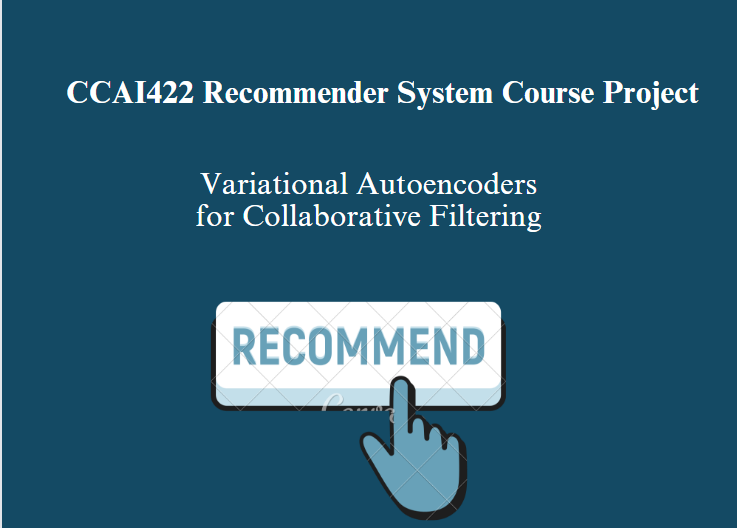





# Team Contributions: 
* ### Bedoor Ayad,
* ### Raneem Alomari 2006352,
* ### Deema Al-saygh.

## Introduction: 
In our journey through a recommendation system course project, we embarked on an exciting exploration of recommendation system and dive deep into its concepts, implement its findings, and push the boundaries of its capabilities to improve and innovate in the field of personalized recommendations. The major challenging “small-data” problem where most users only interact with a tiny proportion of the items and our goal is to collectively make informed inference about each user’s preference . we find that to make use of the sparse signals from users and avoid overfitting, we build a probabilistic latent-variable model that shares statistical strength among users and items. Empirically, we show that employing a principled Bayesian approach is more robust regardless of the scarcity of the data.  However, we did not stop at mere replication. We fine-tuned parameters of the Variational Autoencoders (VAEs) , explored alternative dataset to create a functional system that could generate personalized recommendations.

**This notebook is base on the [Variational Autoencoders for Collaborative Filtering paper] (https://arxiv.org/pdf/1802.05814v1.pdf)**

# Library

In [655]:
!pip install imbalanced-learn

ERROR: Could not find a version that satisfies the requirement scikit-learn>=0.24 (from imbalanced-learn) (from versions: none)
ERROR: No matching distribution found for scikit-learn>=0.24


In [656]:
# Imports the shutil module, which provides high-level file operations.
import shutil  

# Imports the sys module, which provides access to some variables 
#used or maintained by the interpreter and functions that interact strongly with the interpreter.
import sys

# Imports the NumPy library and assigns it the alias 'np' for ease of use.
import numpy as np
# Imports the 'sparse' module from SciPy, which deals with sparse matrix representations.
from scipy import sparse

# Imports the pyplot module from Matplotlib and assigns it the alias 'plt' for plotting purposes.
import matplotlib.pyplot as plt

# Magic command in Jupyter Notebook to display Matplotlib plots inline.
#%matplotlib inline

# Imports the Seaborn library for statistical data visualization and assigns it the alias 'sn'.
import seaborn as sn
# Sets the default Seaborn theme and applies aesthetic preferences
sn.set()

# Imports the Pandas library for data manipulation and analysis and assigns it the alias 'pd'.
import pandas as pd

# Imports the random module, providing functions for generating random numbers.
import random
# Imports TensorFlow, a popular deep learning framework, and assigns it the alias 'tf'.
import tensorflow as tf

# Imports the bottleneck library, which provides specialized array functions.
import bottleneck as bn

# Imports the os module, which provides a way of using operating system dependent functionality.
import os

# Data Loading

In [657]:
#Loading data
raw_data1 = pd.read_csv("/kaggle/input/netflix-movie-rating-dataset/Netflix_Dataset_Rating.csv", header = 0)

# Data visualization :

In [658]:
# Displays the first few rows of the DataFrame 'raw_data', allowing a quick view of its
#structure and contents.
raw_data1.head()

,User_ID,Rating,Movie_ID
0,712664,5,3
1,1331154,4,3
2,2632461,3,3
3,44937,5,3
4,656399,4,3


# Data Preprocessing:

In [659]:
raw_data1.Rating.nunique() # values are integer {5 , 4 , 3, 2, 1}

5

## Binarizing the ratings

There are some database of ratings ranging from 0.5 to 5. so we check if there float we Binarizing data if not then no need for this step. Binarizing the ratings can be useful in certain scenarios, especially when dealing with recommendation systems

In [660]:
# Check if the 'Rating' column contains float values
if raw_data1['Rating'].dtype == 'float64':
    # Binarize the ratings (assuming a threshold, e.g., 3.5)
    threshold = 3.5
    raw_data1['Binarized_Rating'] = (raw_data1['Rating'] >= threshold).astype(int)
    # Drop the original 'Rating' column if needed
    raw_data1 = raw_data1.drop('Rating', axis=1)
    # Now you have a new column 'Binarized_Rating' with 1 for ratings >= threshold and 0 otherwise
    
else:
    # No need to binarize if the ratings are not float
    print("The 'Rating' column is not of float type.")

The 'Rating' column is not of float type.


## Handeling imbalanced data using Undersampling techniques

In [661]:
# Counts the number of ratings equal to 5 in the 'Rating' column of the 'raw_data' DataFrame.
print("# Ratings = 5: ",sum(raw_data1['Rating']==5))

# Counts the number of ratings equal to 4 in the 'Rating' column of the 'raw_data' DataFrame.
print("# Ratings = 4: ",sum(raw_data1['Rating']==4))

# Counts the number of ratings equal to 3 in the 'Rating' column of the 'raw_data' DataFrame.
print("# Ratings = 3: ",sum(raw_data1['Rating']==3))

# Counts the number of ratings equal to 2 in the 'Rating' column of the 'raw_data' DataFrame.
print("# Ratings = 2: ",sum(raw_data1['Rating']==2))

# Counts the number of ratings equal to 1 in the 'Rating' column of the 'raw_data' DataFrame.
print("# Ratings = 1: ",sum(raw_data1['Rating']==1))

# Displays the first few rows of the 'raw_data' DataFrame 
raw_data1.head()

# Ratings = 5:  3769803
# Ratings = 4:  5901368
# Ratings = 3:  5185650
# Ratings = 2:  1759281
# Ratings = 1:  721356


,User_ID,Rating,Movie_ID
0,712664,5,3
1,1331154,4,3
2,2632461,3,3
3,44937,5,3
4,656399,4,3


It seems like the distribution is not perfectly balanced, but it's common to have some class imbalance in real-world datasets. In Our case, Ratings 4 and 3 have more instances compared to others.

**Handling class imbalance is crucial in machine learning, especially when certain classes have significantly fewer instances than others. Here techniques we considered:
Undersampling: Decrease the number of instances in the majority class by randomly removing examples.**

In [662]:
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

# Assuming raw_data is your DataFrame with 'Rating' as the target variable
X = raw_data1.drop('Rating', axis=1)
y = raw_data1['Rating']

# Calculate the target number of instances for each class
target_instances = min(raw_data1['Rating'].value_counts())

# Set the target ratio for each class
undersample_ratio = {1: target_instances, 2: target_instances, 3: target_instances, 4: target_instances, 5: target_instances}

# Apply random undersampling
undersampler = RandomUnderSampler(sampling_strategy=undersample_ratio, random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Now X_resampled and y_resampled contain the undersampled dataset

In [663]:
# Concatenate the undersampled data (X_resampled, y_resampled) with raw_data
raw_data = pd.concat([X_resampled, pd.Series(y_resampled, name='Rating')], axis=1)

# Now raw_data is updated with the undersampled data
raw_data.head()

,User_ID,Movie_ID,Rating
0,2330911,1582,1
1,446767,3220,1
2,2502462,1138,1
3,2402461,483,1
4,122051,2783,1


In [664]:
# Counts the number of ratings equal to 5 in the 'Rating' column of the 'raw_data' DataFrame.
print("# Ratings = 5: ",sum(raw_data['Rating']==5))

# Counts the number of ratings equal to 4 in the 'Rating' column of the 'raw_data' DataFrame.
print("# Ratings = 4: ",sum(raw_data['Rating']==4))

# Counts the number of ratings equal to 3 in the 'Rating' column of the 'raw_data' DataFrame.
print("# Ratings = 3: ",sum(raw_data['Rating']==3))

# Counts the number of ratings equal to 2 in the 'Rating' column of the 'raw_data' DataFrame.
print("# Ratings = 2: ",sum(raw_data['Rating']==2))

# Counts the number of ratings equal to 1 in the 'Rating' column of the 'raw_data' DataFrame.
print("# Ratings = 1: ",sum(raw_data['Rating']==1))

# Ratings = 5:  721356
# Ratings = 4:  721356
# Ratings = 3:  721356
# Ratings = 2:  721356
# Ratings = 1:  721356


now each class has same number of instances

# **Data Splitting Procedure**
* Select 10K users as excluded users, 10K users as validation users, and the remaining users for training.
* Use all items from the training users as the item set.
* For each validation and test user, subsample 80% as fold data and the remainder for prediction.

In [665]:
# Function that counts the number of specific items grouped
# Display the count of occurrences for each unique 'Movie_ID' in the 'raw_data' DataFrame.
print(raw_data[['Movie_ID']].groupby('Movie_ID', as_index=False).size)

# Define a function 'get_count'that takes two parameters: 'data' (DataFrame) 
#and 'item' (specific item to count).
def get_count( data, item ):
    
# Group the data by the specified 'item' and count the occurrences of each group.
    playcount_groupbyid = data[[item]].groupby(item, as_index=False) 
    
# Calculate the count of occurrences for each group and store it in the 'count' variable.
    count = playcount_groupbyid.size()['size']

# Return the count of occurrences for the specified 'item'.
    return count

<bound method GroupBy.size of <pandas.core.groupby.generic.DataFrameGroupBy object at 0x7f86ed0920d0>>


In [666]:
# Calls the 'get_count' function to count the occurrences of unique 'User_ID' values 
#in the 'raw_data' DataFrame.
get_count(raw_data, 'User_ID')

0         28
1         27
2         48
3         32
4         33
          ..
143449     9
143450    10
143451    17
143452     8
143453     9
Name: size, Length: 143454, dtype: int64

##  Filter triples (data, user, item)

In [667]:
#The function of filtered triplets (data, user count, and item count)
def filter_triplets( data, min_uc = 5, min_sc = 5 ):
    # Considering triplets only for items selected by at least min_sc users
    if min_sc > 0:
        
        # Counting the occurrences of each Movie_ID and filtering data based on min_sc threshold
        item_count = get_count( data, 'Movie_ID')
        
        # Filtering data by Movie_IDs meeting the minimum count requirement
        data = data[ data[ 'Movie_ID' ].isin(item_count.index[ item_count >= min_sc ] ) ] 
        
     # Considering triplets for users who interacted with at least min_uc items                                       
    if min_uc > 0:
        
        # Counting the occurrences of each User_ID and filtering data based on min_uc threshold
        user_count = get_count( data, 'User_ID' )
        
        # Filtering data by User_IDs meeting the minimum count requirement
        data = data[ data[ 'User_ID' ].isin(user_count.index[ user_count >= min_uc ] ) ]
        
    # Updating the item and user count after the filters have been applieds
    item_count = get_count( data, 'Movie_ID' )# Recalculating item count after filtering
    user_count = get_count( data, 'User_ID' )# Recalculating user count after filtering
    return data, user_count, item_count

**Considering items that were rated by at least 5 users and users who rated at least 5 movies.**

In [668]:
# Filtering the raw_data DataFrame based on default minimum user and item counts 
#using the filter_triplets function.
# The resulting filtered data, user_activity, and item_popularity are obtained 
#and assigned to the respective variables.
raw_data, user_activity, item_popularity = filter_triplets(raw_data)

## spread metric

The numerator of the spread metric is calculated by counting the total number of ratings contained in the ratings matrix.
The denominator of the spread metric is calculated by multiplying the number of users by the number of movies in the ratings matrix. The spread is calculated and printed by dividing the numerator by the denominator, subtracting 1, and multiplying by 100. Adding 1.0 ensures that the spread is returned as a decimal rather than an integer.

In [669]:
# Calculate the sparsity of the dataset after applying filters
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])
print("After the filters, there are %d events from %d users and %d movies (items) (sparsity: %.3f%%)" %
(raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After the filters, there are 32748 events from 4608 users and 421 movies (items) (sparsity: 1.688%)


In [670]:
# Display the shape (dimensions) of the 'raw_data' DataFrame.
print(raw_data.shape)

# Display the shape (dimensions) of the 'item_popularity' DataFrame.
print(item_popularity.shape)

# Display the shape (dimensions) of the 'user_activity' DataFrame.
print(user_activity.shape)

(32748, 3)
(421,)
(4608,)


In [671]:
# Unique index of users
# Extracting unique user IDs as the index from the 'user_activity' DataFrame
unique_uid = user_activity.index

# Setting a seed for reproducibility before shuffling the indices of users
np.random.seed(98765)

# Creating a random permutation of the indices' size to shuffle the unique user IDs
idx_perm = np.random.permutation(unique_uid.size)

# Reordering the unique user IDs based on the permutation
unique_uid = unique_uid[idx_perm]

# Printing the size (number of elements) of the unique user ID array after shuffling
print(unique_uid.size)

4608


**Creating train/validation/test sets for users**

In [672]:
# Calculating the total number of unique users in the dataset
n_users = unique_uid.size


# Setting the number of users to be held out or excluded from the dataset

# n_heldout_users represents the number of users that won't be included 
#in the training/validation/test sets
n_heldout_users = 1000 

# Creating training set users by taking all users except the last n_heldout_users * 2 users
tr_users = unique_uid[:(n_users - n_heldout_users * 2)]

# Creating validation set users by taking the users from
#n_users - n_heldout_users * 2 to n_users - n_heldout_users
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)] 


# Creating test set users by taking the last n_heldout_users users
te_users = unique_uid[(n_users - n_heldout_users):]

In [673]:
# Selecting all the training users' data from our raw_data

# Filtering raw_data to include only rows where the 'User_ID' 
#is present in the tr_users list (training set users)
train_plays = raw_data.loc[raw_data['User_ID'].isin(tr_users)]
train_plays

,User_ID,Movie_ID,Rating
3120,3423,720,1
5698,3458,1289,1
6638,3595,749,1
6996,3871,438,1
23306,695,8,1
...,...,...,...
3580789,3786,1180,5
3587513,2385,329,5
3593365,3210,28,5
3598161,3786,1324,5


In [674]:
# Unique movies without repetition
# Extracting unique movie IDs from the 'Movie_ID' column of the train_plays DataFrame
unique_sid = pd.unique( train_plays[ 'Movie_ID'] )
unique_sid

array([ 720, 1289,  749,  438,    8,  528,  457, 1046,  723,  953,  571,
       1267,  199,  341,  197, 1027, 1145,  843,   77, 1245,  937,  148,
       1202,  334,  329,  554,  187, 1116,  273,  398,  285, 1307,  894,
       1100,  672,  175,  331,  494,  788,  353,  964,  416,   30,  313,
       1073, 1102,  295,  662,  468,  977,  483,   55,  829,  751,  191,
        482,  708, 1110, 1250,  427,  390,  256,  846,  985,  551,  223,
        986,  424,  108,  127,  413,  692,  918,  660,  312,  289,  758,
        406, 1255,  956,  255,  111,  473,  730,  789,  357,   17,  356,
        798,  311, 1180,  989,  564,  763, 1305,  993,  305,  189,  283,
       1172,  269, 1096,  818,  643,  213,  550,  674, 1216,  668, 1144,
       1262,  722,  659,  759,  831,  330, 1295, 1324,  670,  299,  711,
        143,  705, 1055,  281,  607,  621, 1050, 1224, 1075,  754,  290,
       1201,  896, 1012, 1336,  118,  445, 1066,  886, 1068,   83, 1173,
        859,  907, 1174, 1058,  686,  548, 1329,  9

In [675]:
# Dictionary for users

# Creating a dictionary 'profile2id' where user IDs are mapped to unique numerical indices 
profile2id = dict((pid,i) for (i, pid) in enumerate(unique_uid))

# Printing the length (number of items) in the 'profile2id' dictionary
print(len(profile2id))

# Dictionary for movies (enumerating the indices)
# Creating a dictionary 'show2id' where movie IDs are mapped to unique numerical indices
show2id   = dict((sid, i) for (i, sid) in enumerate(unique_sid))

# Printing the length (number of items) in the 'show2id' dictionary
print(len(show2id))

4608
219


**Writing movie files**

In [676]:
# Defining the directory path where the files will be stored
DATA_DIR = ''
pro_dir = os.path.join(DATA_DIR, 'pro_sg')

# Checking if the directory 'pro_dir' does not exist; if not, create the directory
if not os.path.exists(pro_dir):
    os.makedirs(pro_dir)

# Writing unique movie IDs to a text file named 'unique_sid.txt'
# Opening a file named 'unique_sid.txt' in write mode within the 'pro_dir' directory
with open(os.path.join(pro_dir, 'unique_sid.txt'), 'w') as f:
     # Writing each unique movie ID from the 'unique_sid' array to the file
    for sid in unique_sid:
        f.write('%s\n' % sid)

**Function to generate training data and test data**

In [677]:
# Function to split data into training and test sets based on user proportions
def split_train_test_proportion(data, test_prop=0.2):
    # Grouping data by 'User_ID'
    data_grouped_by_user = data.groupby('User_ID') 
    
    # Initializing lists to hold training and test data
    tr_list, te_list = list(), list() 
    
    # Setting a seed for random number generation
    np.random.seed(98765)

    # Iterating through each group (user) in the grouped data
    for i, (_, group) in enumerate(data_grouped_by_user):
        # Calculating the number of items per user
        n_items_u = len(group) 

        # If the user has at least 5 items
        if n_items_u >= 5:
            # Creating a boolean mask for the test items
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

             # Adding the items to the training and test lists based on the mask
            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            # If the user has less than 5 items, add all items to the training set
            tr_list.append(group)
            
        # Printing progress every 10 users sampled
        if i % 10 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()
            
    # Concatenating the training and test data from the lists
    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te

In [678]:
# Location of users in the test data

# Filtering raw_data to include only rows where the 'User_ID' 
# is present in the vd_users list (validation set users)
vad_plays = raw_data.loc[raw_data['User_ID'].isin(vd_users)]

# Further filtering vad_plays to include only rows where the 'Movie_ID'
#is present in the unique_sid list (unique movie IDs)
vad_plays = vad_plays.loc[vad_plays['Movie_ID'].isin(unique_sid)]
vad_plays

,User_ID,Movie_ID,Rating
22362,1333,1267,1
24769,4439,361,1
49841,1427,187,1
138841,4439,964,1
155937,1333,127,1
...,...,...,...
3467266,527,571,5
3486848,3392,270,5
3528253,788,443,5
3558040,3487,1110,5


In [679]:
# Splitting validation data of movies for validation users into train and test data sets
# Using the previously defined function split_train_test_proportion to divide the vad_plays
#DataFrame into training and test sets
vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

0 users sampled
10 users sampled
20 users sampled


In [680]:
# Location of users in the test data

# Filtering raw_data to include only rows where the 'User_ID' 
#is present in the te_users list (test set users)
test_plays = raw_data.loc[raw_data['User_ID'].isin(te_users)]

# Further filtering test_plays to include only rows where the 'Movie_ID' 
#is present in the unique_sid list (unique movie IDs)
test_plays = test_plays.loc[test_plays['Movie_ID'].isin(unique_sid)]

In [681]:
# Splitting test data of movies for test set users into train and test data sets
# Using the previously defined function split_train_test_proportion to
test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)

0 users sampled
10 users sampled
20 users sampled


**Saving the data in user_index and item_index formats**

In [682]:
# Function to numerize the data by mapping user and movie IDs to numerical indices
def numerize(data):
    # Mapping 'User_ID' values to corresponding numerical indices using the 'profile2id' dictionary
    uid = list(map(lambda x: profile2id[x], data['User_ID']))
    # Mapping 'Movie_ID' values to corresponding numerical indices using the 'show2id' dictionary
    sid = list(map(lambda x: show2id[x],   data['Movie_ID']))
    # Creating a new DataFrame with numerical indices for users ('uid') and movies ('sid')
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [683]:
# Converting the training data to numerical indices using the 'numerize' function
train_data = numerize(train_plays)

# Saving the training data to a CSV file named 'train.csv' 
#in the 'pro_dir' directory without including the index
train_data.to_csv(os.path.join(pro_dir, 'train.csv'), index=False)

In [684]:
# Converting the validation training data to numerical indices using the 'numerize' function
vad_data_tr = numerize(vad_plays_tr)

# Saving the validation training data to a CSV file named 'validation_tr.csv'
#in the 'pro_dir' directory without including the index
vad_data_tr.to_csv(os.path.join(pro_dir, 'validation_tr.csv'), index=False)

In [685]:
# Converting the validation test data to numerical indices using the 'numerize' function
vad_data_te = numerize(vad_plays_te)

# Saving the validation test data to a CSV file named 'validation_te.csv' 
#in the 'pro_dir' directory without including the index
vad_data_te.to_csv(os.path.join(pro_dir, 'validation_te.csv'), index=False)

In [686]:
# Converting the test training data to numerical indices using the 'numerize' function
test_data_tr = numerize(test_plays_tr)

# Saving the test training data to a CSV file named 'test_tr.csv' 
#in the 'pro_dir' directory without including the index
test_data_tr.to_csv(os.path.join(pro_dir, 'test_tr.csv'), index=False)

In [687]:
# Converting the test test data to numerical indices using the 'numerize' function
test_data_te = numerize(test_plays_te)

# Saving the test test data to a CSV file named 'test_te.csv' 
#in the 'pro_dir' directory without including the index
test_data_te.to_csv(os.path.join(pro_dir, 'test_te.csv'), index=False)

# **MODEL DEFINITION AND TRAINING**

**Notation:**
Let $u\in \{1,...,U\}$  be the indices of users and $i\in\{1,...,I\}$ be the indices of items. The user-item interaction matrix is $X\in\mathbb{N}^{U\times I}$. The interaction matrix is binarized.

**Generative Process:**
For each user $u$, the model starts by sampling the  $K$-dimensional latent representation  $\mathbf{z}_u$ from a standard Gaussian prior. The latent representation  $\mathbf{z}_u$ is transformed by a non-linear function $f_\theta (\cdot) \in \mathbb{R}^I$to produce a probability distribution over $I$  items $\pi (\mathbf{z}_u)$ from which the interaction history $\mathbf{x}_u$ is assumed to be
$$
\mathbf{z}_{u} \sim \mathscr{N}\left(0, \mathbf{I}_{K}\right), \pi\left(\mathbf{z}_{u}\right) \propto \exp \left\{f_{\theta}\left(\mathbf{z}_{u}\right)\}, \mathbf{x}_{u} \sim \operatorname{Mult}\left(N_{u}, \pi\left(\mathbf{z}_{u}\right)\right)\right.
$$
The objective of Multi-DAE for a single user $u$ is:
$$
\mathscr{L}_{u}(\theta, \phi)=\log p_{\theta}\left(\mathbf{x}_{u} \mid g_{\phi}\left(\mathbf{x}_{u}\right)\right)
$$
where $g_{\phi}(\cdot)$ is the non-linear "encoder" function.

* The *Saver* class adds operations to save and restore variables to and from checkpoints. It also offers convenient methods to execute these operations.
* tf.contrib.layers.xavier_initializer: Generates samples from a truncated normal distribution centered on 0 with standard deviation = sqrt(2 / (fan_in + fan_out)), where fan_in represents the number of input units in the weight tensor and fan_out represents the number of output units in the weight tensor.

# Multinomial Blurring Autoencoder Model

**Autoencoders:**
An autoencoder takes inputs $x\in[0,1]^d$ and first maps it (with an encoder) to a latent representation $h\in[0,1]^{d^\prime}$ through a deterministic mapping
$$h=Wx+b,$$
where $W$ represents the weight matrix and $b$ the bias vector. 

The latent representation $h$  is then mapped back (with the decoder) into a reconstruction $z$ of the same size as $x$ through a similar transformation, i.e.,
$$z= (W^\prime h + b^\prime).$$
$z$ is expected to be a prediction of $x$. The weight matrix $W^\prime$ for the inverse mapping can be constructed as $W^\prime=W^T$.

We aim to minimize
$$\min_\theta\|x-z\|^2$$

# building MultiDAE

In [688]:
##Clase de funciones para MULTINOMIAL DENOISING AUTOENCODERS (MULT-DAE)
class MultiDAE(object):
    '''Arguments:
        p_dims = decoder dimension,
        q_dims = encoder dimension,
        lam = regularization parameter,
        lr = learning rate'''
    def __init__(self, p_dims, q_dims=None, lam=0.01, lr=1e-3, random_seed=None):
         # Initializes the Multi-DAE class with decoder and encoder dimensions,
            #regularization parameter, learning rate, and random seed
        self.p_dims = p_dims
        if q_dims is None: 
            self.q_dims = p_dims[::-1]
        else:
            assert q_dims[0]  == p_dims[-1], "Input and output dimensions must be the same for autoencoders."
            assert q_dims[-1] == p_dims[0], "Latent dimension for the mismatches of p- and q-networks."
            self.q_dims = q_dims
        self.dims   = self.q_dims + self.p_dims[1:] 

        self.lam = lam
        self.lr  = lr
        self.random_seed = random_seed

        self.construct_placeholders()

    def construct_placeholders(self):
        # Constructs placeholder variables for input data and dropout probability
        tf.compat.v1.disable_eager_execution()
        self.input_ph     = tf.compat.v1.placeholder( dtype=tf.float32, shape=[None, self.dims[0]])#matrix
        self.keep_prob_ph = tf.compat.v1.placeholder_with_default( 1.0, shape=None) #Returns a value between 0 and 1.
    #Latent Representation
    def forward_pass(self):
        # Performs the forward pass through the network architecture
        h = tf.compat.v1.nn.l2_normalize( self.input_ph, 1) #L2 norm of a matrix... returns a vector of the same length as the input
        # Computes dropout: randomly sets elements to zero to prevent overfitting
        h = tf.compat.v1.nn.dropout( h, self.keep_prob_ph ) #With a probability rate, elements of x are set to 0. 
        #The remaining elements are scaled up by 1.0 / (1 - rate) so that the expected value is preserved.
        #(To avoid overfitting) # construct vector y
        for i, (w,b) in enumerate(zip(self.weights, self.biases)):
            h = tf.compat.v1.matmul(h,w)+b #Latent Representation
            if i != len(self.weights)-1: #For the last layer.
                h = tf.compat.v1.nn.tanh(h) #Activation function
        return tf.compat.v1.train.Saver(), h

    def construct_weights(self):
        # Constructs weights and biases for the network layers
        self.weights = []
        self.biases  = []
        #I define weights.
        for i, (d_in,d_out) in enumerate(zip(self.dims[:-1],self.dims[1:])): #Enumerates dimensions of encoder and decoder.
            weight_key = "Weight_{}to_{}".format(i,i+1) #Names
            bias_key   = "Bias_{}".format(i+1)
           #Creating new variables (weights) with TensorFlow
           #Weight matrix
            self.weights.append(tf.compat.v1.get_variable( name = weight_key, shape = [d_in, d_out],
                                          initializer = tf.keras.initializers.glorot_normal(seed = self.random_seed)))
            #Bias vector
            self.biases.append(tf.compat.v1.get_variable( name = bias_key, shape = [d_out],
                                          initializer = tf.compat.v1.truncated_normal_initializer(stddev=0.001,
                                                                                        seed = self.random_seed)))
            #Adding statistical summary
            tf.compat.v1.summary.histogram( weight_key, self.weights[-1])
            tf.compat.v1.summary.histogram( bias_key, self.biases[-1])
    def loss(self):
        # Defines the loss function using negative log-likelihood and L2 regularization
        with tf.GradientTape() as tape:
            with tf.compat.v1.Session() as sess:
                saver, logits = self.forward_pass()
                log_softmax_var = tf.compat.v1.nn.log_softmax(logits)
                neg_ll = -tf.compat.v1.reduce_mean(tf.reduce_sum(log_softmax_var * self.input_ph, axis=1))
                reg_var = tf.compat.v1.nn.l2_loss(self.lam)
                return neg_ll + 2.0 * reg_var
        train_op = tf.optimizers.Adam(self.lr).minimize(loss, var_list=[self.weights,self.biases])
        return train_op
    def build_graph(self):
# Constructs the computational graph for 
#the Multi-DAE model, including forward pass, loss calculation, optimizer, and summaries
        self.construct_weights()

        saver, logits = self.forward_pass()
        log_softmax_var = tf.compat.v1.nn.log_softmax(logits)
        neg_ll = -tf.compat.v1.reduce_mean(tf.compat.v1.reduce_sum(log_softmax_var * self.input_ph, axis=1))
        reg_var = tf.add_n([ tf.nn.l2_loss(v) for v in self.weights ])
        print(np.shape(self.weights))
        loss    = neg_ll + 2.0 * reg_var 
        train_op = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(loss)#self.loss()
        #train_op = tf.optimizers.Adam(self.lr).minimize(loss, var_list=[self.weights,self.biases])
        # add summary statistics
        tf.compat.v1.summary.scalar('negative_multi_ll', neg_ll)
        tf.compat.v1.summary.scalar('loss', loss)
        merged = tf.compat.v1.summary.merge_all()
        return saver, logits, loss, train_op, merged

# Autoencoder Variacional Multinomial

The objective function of Multi-VAE $^{PR}$ (Evidence Lower Bound - ELBO) for a user  $u$ u is given by :
$$
\mathcal{L}_u(\theta, \phi) = \mathbb{E}_{q_\phi(z_u | x_u)}[\log p_\theta(x_u | z_u)] - \beta \cdot KL(q_\phi(z_u | x_u) \| p(z_u))
$$
Here, $q_\phi$ is the approximate variational distribution (inference model), $\beta$  is an additional control parameter. The dataset's objective function is the average over all users. Training can be performed similarly to Multi-DAE thanks to the reparameterization trick.
The Kullback-Leibler divergence is defined as: 
$$
\operatorname{KL}\left(q\left(\mathrm{z}_{u}\right) \| p\left(\mathrm{z}_{u} \mid \mathrm{x}_{u}\right)\right)=\int_{-\infty}^{\infty} q\left(\mathrm{z}_{u}\right) \ln \frac{q\left(\mathrm{z}_{u}\right)}{p\left(\mathrm{z}_{u} \mid \mathrm{x}_{u}\right)} \mathrm{d} z_{u}
$$

Assuming two distributions with parameters
 $q(z_u) \sim N\left(\mu_u,diag\{ \sigma^{2}_u\}\right)$ y $p(z_u) \sim N(0,I_K)$.
 
To provide further context in terms of latent variable models, the goal is to approximate a posterior to the true posterior by minimizing the KL divergence. Here, $ z_u $ represents the latent variable, $q(z_u)$ is the approximate distribution, and $ p(z_u) $ is the prior distribution. The parameters of  $q$  are the output from the encoder.

For Gaussian distributions, the KL divergence is given by:

$$
\begin{aligned}
K L(q \| p) &=\frac{1}{2} \log (2 \pi)+\frac{1}{2}\left(\mu^{2}+\sigma^{2}\right)-\frac{1}{2} \log (2 \pi)-\frac{1}{2} \log \left(\sigma^{2}\right)-\frac{1}{2} \\
&=-\frac{1}{2}\left(1+\log \left(\sigma^{2}\right)+-\mu^{2}-\sigma^{2}\right)
\end{aligned}
$$
This equation can be generalized for multivariate cases by summing across all dimensions, i.e.,
$$
K L(q \| p)=-\frac{1}{2} \sum_{d=1}^{D}\left(1+\log \left(\sigma_u^{2}\right)+-\mu_u^{2}-\sigma_u^{2}\right)
$$
For more information on KL divergence, please refer to

https://leenashekhar.github.io/2019-01-30-KL-Divergence/

q_dims = dimension of the encoder layers
$\mu=x_{ui}[:,:qdims[-1]]$, $qdims[-1]$ is the dimension of the last layer of the encoder.

$\log(var)=x_{ui}[:,qdims[-1]:]$

$\sigma = e^{0.5*\log(var)}$

# Bulding MultiVEA that takes MultiDAE as input

In [689]:
class MultiVAE(MultiDAE):
    def construct_placeholders(self):#Building variables
        # Inherits and constructs placeholders from the parent class (MultiDAE)
        super(MultiVAE, self).construct_placeholders() #This function allows us to invoke
        # Define additional placeholders with default values for scoring
         #preserve a method or attribute of a parent (parent) class from a child (secondary) class
         #without having to name it explicitly.
         # placeholders with default values when scoring
        self.is_training_ph = tf.compat.v1.placeholder_with_default(0., shape=None)
        self.anneal_ph = tf.compat.v1.placeholder_with_default(1., shape=None)

    def build_graph(self):
         # Constructs the computational graph for the MultiVAE model
        self._construct_weights() # Constructs weights for encoder and decoder
        saver, logits, KL = self.forward_pass() # Performs forward pass through the network
        log_softmax_var = tf.compat.v1.nn.log_softmax(logits) # Activation function
        neg_ll = -tf.compat.v1.reduce_mean(tf.reduce_sum(log_softmax_var*self.input_ph,axis=-1))
        #Aplicando regularización a los pesos
        reg_var = tf.add_n([ tf.nn.l2_loss(v) for v in (self.weights_q + self.weights_p) ])
        # tensorflow l2 regularization multiply 0.5 to the l2 norm
        # multiply 2 so that it is back in the same scale
        neg_ELBO = neg_ll + self.anneal_ph * KL + 2.0 * reg_var  # Equation 5, regularization term added
        # Optimizes parameters
        train_op = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(neg_ELBO)

        # Summary statistics
        tf.compat.v1.summary.scalar('negative_multi_ll', neg_ll)
        tf.compat.v1.summary.scalar('KL', KL)
        tf.compat.v1.summary.scalar('neg_ELBO_train', neg_ELBO)
        merged = tf.compat.v1.summary.merge_all() # Merges all the summary statistics

        return saver, logits, neg_ELBO, train_op, merged


# Encoder
    def q_graph(self): 
        mu_q, std_q, KL = None, None, None
        h = tf.compat.v1.nn.l2_normalize( self.input_ph, 1)
        h = tf.compat.v1.nn.dropout( h, self.keep_prob_ph )
        print(h)
        for i, (w,b) in enumerate(zip(self.weights_q,self.biases_q)): 
            #print("W", w)
            #print("b: ", b)
            #print("Hereee: ", tf.compat.v1.matmul(h,w)) #HERE IS THE PROBLEM 
            h = tf.compat.v1.matmul(h,w) + b
            
            if i != len(self.weights_q)-1:
                h = tf.compat.v1.nn.tanh(h)
                
            else: 
                #The dimension of the last encoder layer (q_dims) is doubled
                mu_q     = h[:,:self.q_dims[-1]] #Mean matrix xiu[:,:dim_out] encoder dim_out
                logvar_q = h[:,self.q_dims[-1]:] 
                std_q    = tf.exp(0.5*logvar_q)
                KL       = tf.compat.v1.reduce_mean(tf.reduce_sum(0.5*(-logvar_q+tf.exp(logvar_q)+mu_q**2-1),
                                                            axis = 1))
        return mu_q, std_q, KL
    
 # Decoder
    def p_graph(self,z): 
        h = z
        for i, (w,b) in enumerate(zip(self.weights_p,self.biases_p)):
            h = tf.compat.v1.matmul(h,w)+b #Latent representation matrix
            if i != len(self.weights_p)-1:
                h = tf.compat.v1.nn.tanh(h)
        return h
    def forward_pass(self): # Latent space calculation
        #q-network
        #print("here")
        mu_q, std_q, KL = self.q_graph()
        #print(tf.shape(std_q))
        epsilon         = tf.random.normal(tf.shape(std_q)) #RandomEpsilon
        sampled_z       = mu_q + self.is_training_ph*\
            epsilon*std_q #Reparametrization
        #p-network
        logits = self.p_graph(sampled_z)
        return tf.compat.v1.train.Saver(), logits, KL #train.Saver saves and restores variables


    def _construct_weights(self):
         # Constructs weights and biases for the encoder
        self.weights_q = []
        self.biases_q  = []
        for i, (d_in, d_out) in enumerate(zip(self.q_dims[:-1],self.q_dims[1:])):
            if i == len(self.q_dims[:-1])-1:#penúltima capa para el conjunto de parámetros (media y varianza)
                d_out *= 2
            weight_key = "Weight_q_{}_to{}".format(i,i+1)
            bias_key   = "Bias_q_{}".format(i+1)

            self.weights_q.append(tf.compat.v1.get_variable( name = weight_key, shape = [d_in, d_out],
                            initializer = tf.keras.initializers.glorot_normal(seed = self.random_seed)))
            self.biases_q.append(tf.compat.v1.get_variable( name = bias_key, shape = [d_out], 
                            initializer = tf.compat.v1.truncated_normal_initializer(stddev=0.001,
                                                                                seed = self.random_seed)))
        # Adding statistical summary
        tf.compat.v1.summary.histogram(weight_key, self.weights_q[-1])
        tf.compat.v1.summary.histogram(bias_key, self.biases_q[-1])

         # Constructs weights and biases for the decoder 
        self.weights_p = []
        self.biases_p  = []
        for i, (d_in, d_out) in enumerate(zip(self.p_dims[:-1],self.p_dims[1:])):
            weight_key = "Weight_p_{}_to_{}".format(i,i+1)
            bias_key   = "Bias_p_{}".format(i+1)

            self.weights_p.append(tf.compat.v1.get_variable( name = weight_key, shape = [d_in, d_out],
                            initializer = tf.keras.initializers.glorot_normal(seed = self.random_seed)))
            self.biases_p.append(tf.compat.v1.get_variable( name = bias_key, shape = [d_out], 
                            initializer = tf.compat.v1.truncated_normal_initializer(stddev=0.001,
                                                                                seed = self.random_seed)))
        # Adding statistical summary
        tf.compat.v1.summary.histogram(weight_key, self.weights_p[-1])
        tf.compat.v1.summary.histogram(bias_key, self.biases_p[-1])

# Training and Validation of Data

We load the preprocessed training and validation data

In [690]:
unique_sid = list()# Initializes an empty list to store unique identifiers of items (movies)
#Movie data (indexes)

# Reading movie data (indices) from a file and populating the unique_sid list
with open(os.path.join(pro_dir, 'unique_sid.txt'), 'r') as f:
    for line in f:
        # Appends each line (movie index) after stripping any leading/trailing whitespaces
        unique_sid.append(line.strip())
    # Calculates the number of items by determining the length of the unique_sid list 
    #(number of unique movie indices)
n_items = len(unique_sid)

In [691]:
# Function to load training data from a file
def load_train_data(file):
    dat     = pd.read_csv(file)# Reads data from the specified file using Pandas
    n_users = dat['uid'].max()+1# Calculates the number of users by finding the maximum user ID and adding 1
    
    rows    = dat['uid'] # Selects the 'uid' column of the data
    cols    = dat['sid'] # Selects the 'sid' (movie index) column of the data
    
    # Constructs a sparse matrix with user-item interactions
    data    = sparse.csr_matrix((np.ones_like(rows),(rows, cols)),
                    dtype = 'float64', shape=(n_users,n_items))
    
    return data # Returns the constructed sparse matrix representing the user-item interactions

In [692]:
# Loading training data by calling the previously defined function 'load_train_data'
# The function reads the 'train.csv' file located in the 'pro_dir' directory
train_data = load_train_data(os.path.join(pro_dir, 'train.csv'))

In [693]:
type(train_data) # Determines and displays the data type of the variable 'train_data'

scipy.sparse.csr.csr_matrix

In [694]:
# Function to load validation data
def load_tr_te_data(file_tr,file_te):# Reading data from training and testing files
    dat_tr = pd.read_csv(file_tr) # Loading data from training file
    dat_te = pd.read_csv(file_te) # Loading data from testing file
    # Range of item indices
    start_idx = min(dat_tr['uid'].min(),dat_te['uid'].min())# Finding the minimum user ID between training and testing data
    end_idx   = max(dat_tr['uid'].max(),dat_te['uid'].max())# Finding the maximum user ID between training and testing data
    
    # Creating row and column indices for training data
    rows_train = dat_tr['uid']-start_idx
    cols_train = dat_tr['sid']
    
    # Creating row and column indices for testing data
    rows_test  = dat_te['uid']-start_idx
    cols_test  = dat_te['sid']
    
    # Creating a sparse matrix for training data
    data_train = sparse.csr_matrix((np.ones_like(rows_train),(rows_train, cols_train)),
                               dtype = 'float64', shape=(end_idx-start_idx+1,n_items)) #converting to sparse matrix
     # Creating a sparse matrix for testing data
    data_test  = sparse.csr_matrix((np.ones_like(rows_test),(rows_test, cols_test)),
                               dtype = 'float64', shape=(end_idx-start_idx+1,n_items)) #converting to sparse matrix
    return data_train, data_test # Returning the generated training and testing data

In [695]:
# Loading validation data by calling the function load_tr_te_data
# Loading training and testing data files from specified paths using os.path.join
val_data_train,val_data_test = load_tr_te_data(os.path.join(pro_dir,'validation_tr.csv'),
                                               os.path.join(pro_dir,'validation_te.csv'))

In [696]:
type(val_data_test)# Checking the data type of the variable val_data_test

scipy.sparse.csr.csr_matrix

# Training hyperparameters:

In [697]:
# Slicing the train_data to the first 10,000 rows and all columns
train_data = train_data[:10000,:]

# Obtaining the number of rows (observations) in the train_data
N = train_data.shape[0]  # 115308 observations initially, but only using the first 10,000 rows here

# Creating a range of indices from 0 to N-1
idxlist = range(N) # Range of indices for the train_data

# Determining batch size for training
batch_size = 500

# Calculating the number of batches per epoch based on the batch size
val = np.ceil(float(N)/batch_size) # Calculating the number of batches
batches_per_epoch = int(val) # Converting to an integer using np.ceil to round up

# Obtaining the number of observations in the validation data (val_data_train)
N_vad = val_data_train.shape[0]  # Number of observations in the validation dataset

# Creating a range of indices for the validation dataset
idxlist_vad = range(N_vad) # Range of indices for the validation dataset

# Setting batch size for validation
batch_size_vad = 20000 # Batch size for validation data

# Total number of gradient updates for annealing 
# prevent the model from getting stuck in local minima and to improve convergence.
total_anneal_steps = 2000000 # Total steps for gradient updates for annealing

# Annealing parameter (maximum value)
# As the annealing process progresses, this parameter is likely to increase, but it won't go beyond the specified cap.
anneal_cap = 0.9 # Annealing parameter, a maximum value used in the annealing process

# Evaluate function: 
Normalized discounted cumulative gain (NDCG@k) and Recall@k

**Discounted Cumulative Gain (DCG)** is the metric to measure the quality of the classification. It is mainly used in information retrieval problems, such as measuring the effectiveness of the search engine's algorithm by ranking the articles it displays according to their relevance in terms of the search keyword.

In [698]:

def NDCG_binary_at_k_batch(X_pred, heldout_batch, k):
    '''
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    # Number of users in the batch
    batch_users = X_pred.shape[0]
    
    # Finding the indices partitioned to the top-k values
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    
    # Extracting the top-k values for each user
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    
    # Sorting the indices of top-k values
    idx_part = np.argsort(-topk_part, axis=1)
    
    # Sorting the top-k predicted scores
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    
    # Building the discount template based on the position
    tp = 1. / np.log2(np.arange(2, k + 2))
    
    # Calculating Discounted Cumulative Gain (DCG)
    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis],
                         idx_topk].toarray() * tp).sum(axis=1)
    
    # Calculating Ideal Discounted Cumulative Gain (IDCG)
    IDCG = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])
    return DCG / IDCG

In [699]:
def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]
    
    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

# Multi-DAE Training & Validation

multilayer perceptron (MLP) with symmetrical architecture. The generative function is a [200 -> 600 -> n_items] MLP, which means the inference function is a [n_items -> 600 -> 200] MLP. Thus the overall architecture for the Multi-VAE^{PR} is [n_items -> 600 -> 200 -> 600 -> n_items].

In [700]:
# Defining the dimensions for the neural network layers
# The first layer has 200 units/neurons and represents the latent factors
# The second layer represents the number of items in the dataset
p_dims = [200, n_items]
#Defining Output dimensions for the neural network layers
q_dims = [n_items, 600, 200]

In [701]:
# Resetting the default TensorFlow graph
tf.compat.v1.reset_default_graph()

# Creating an instance of the MultiDAE class with specified parameters
# p_dims: dimensions for the neural network layers
# lam: regularization parameter for the model
# random_seed: seed for random number generation
dae = MultiDAE(p_dims, lam=0.01 / batch_size, random_seed=98765)

# Building the TensorFlow computation graph for the DAE model
saver, logits_var, loss_var, train_op_var, merged_var = dae.build_graph()

# Creating a TensorFlow variable initialized with a value of 0.0 for NDCG evaluation
ndcg_var = tf.Variable(0.0)

# Placeholder for NDCG values of type float64 with unspecified shape
ndcg_dist_var = tf.compat.v1.placeholder(dtype=tf.float64, shape=None)

# Creating a summary for NDCG at k for validation
ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)

# Creating a summary for the histogram of NDCG at k for validation
ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)

# Merging the NDCG summary and histogram summaries into a single summary
# merged_valid = tf.compat.v1.summary.merge([ndcg_summary, ndcg_dist_summary])

(2,)


In [702]:
ndcg_dist_summary# Outputting the summary for the histogram of NDCG at k for validation
print(ndcg_dist_summary)
print(logits_var)# Printing the variable 'logits_var'

Tensor("ndcg_at_k_hist_validation/write_summary/Const:0", shape=(), dtype=bool)
Tensor("add_1:0", shape=(None, 219), dtype=float32)


In [703]:
n_epochs = 200 # Setting the number of epochs for training to 200

In [704]:
arch_str = "I-%s-I" % ('-'.join([str(d) for d in dae.dims[1:-1]]))

In [705]:
chkpt_dir = '/volmount/chkpt/ml-20m/DAE/{}'.format(arch_str)
if not os.path.isdir(chkpt_dir):
    os.makedirs(chkpt_dir) 
    
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: /volmount/chkpt/ml-20m/DAE/I-200-I


In [706]:
ndcgs_vad = []# Empty list to store NDCG values for validation
i=0 # Counter variable initialization
n100_list, r20_list, r50_list = [], [], []
# TensorFlow session context manager
with tf.compat.v1.Session() as sess:
# Initializing global variables within the session
    init = tf.compat.v1.global_variables_initializer()
    sess.run(init)
    
# Initializing the best NDCG variable to negative infinity
    best_ndcg = -np.inf
    
    # Looping through the specified number of epochs for training
    for epoch in range(n_epochs):
        i+=1 # Incrementing the counter
        
        # Shuffling the index list for training
        idxlist = random.sample(list(idxlist), len(list(idxlist)))
        
        # Training for one epoch
        for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)
            X = train_data[idxlist[st_idx:end_idx]]
            # Preparing input data for training
            
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')  
            
            # Creating a feed dictionary for the model training
            feed_dict = {dae.input_ph: X, 
                         dae.keep_prob_ph: 0.5} 
            
            # Running the training operation for the model
            sess.run(train_op_var, feed_dict=feed_dict)
            
            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
                #summary_writer.add_summary(summary_train, global_step=epoch * batches_per_epoch + bnum) 
        
        # Computing validation NDCG
        ndcg_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
#            print()
            X = val_data_train[idxlist_vad[st_idx:end_idx]]
            #print("X",X)
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')
            
            # Getting predictions for validation data
            pred_val = sess.run(logits_var, feed_dict={dae.input_ph: X} )
        
            # Excluding examples from training and validation (if any)
            pred_val[X.nonzero()] = -np.inf
            #print("Validation: ",NDCG_binary_at_k_batch(pred_val, val_data_test[idxlist_vad[st_idx:end_idx]]))
            #print(pred_val)
            #Calculating NDCG for validation data
            ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, val_data_test[idxlist_vad[st_idx:end_idx]], k=100))
            r20_list.append(Recall_at_k_batch(pred_val, val_data_test[idxlist_vad[st_idx:end_idx]], k=20))
            r50_list.append(Recall_at_k_batch(pred_val, val_data_test[idxlist_vad[st_idx:end_idx]], k=50))
            #print("List: ", ndcg_dist)
        
        print("Iteration: ", i )# Printing iteration and mean NDCG for validation
        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_dist = np.nan_to_num(ndcg_dist)
        ndcg_ = ndcg_dist.mean() * 100
        print("Mean NDCG: ", ndcg_)
        
         # Appending the mean NDCG to the list
        ndcgs_vad.append(ndcg_)
    

r20_list = np.concatenate(r20_list)
r50_list = np.concatenate(r50_list)        

Iteration:  1
Mean NDCG:  0.09330675132699187
Iteration:  2
Mean NDCG:  0.11444963009987835


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Iteration:  3
Mean NDCG:  0.1411779941215017
Iteration:  4
Mean NDCG:  0.20059498314589516
Iteration:  5
Mean NDCG:  0.23355260371425768
Iteration:  6
Mean NDCG:  0.2544972791528825
Iteration:  7
Mean NDCG:  0.27215390319446914
Iteration:  8
Mean NDCG:  0.29519160555860396
Iteration:  9
Mean NDCG:  0.30720563323076494
Iteration:  10
Mean NDCG:  0.31626373948180997
Iteration:  11
Mean NDCG:  0.3206331027274509
Iteration:  12
Mean NDCG:  0.3460541065034564
Iteration:  13
Mean NDCG:  0.34680365144078307
Iteration:  14
Mean NDCG:  0.3500125021770373
Iteration:  15
Mean NDCG:  0.35144857825068043
Iteration:  16
Mean NDCG:  0.3683087535804464
Iteration:  17
Mean NDCG:  0.36989300482931203
Iteration:  18
Mean NDCG:  0.36921810270189187
Iteration:  19
Mean NDCG:  0.3705425366159239
Iteration:  20
Mean NDCG:  0.3943470203617531
Iteration:  21
Mean NDCG:  0.3944312780084589
Iteration:  22
Mean NDCG:  0.3940846144773942
Iteration:  23
Mean NDCG:  0.39724055394896923
Iteration:  24
Mean NDCG:  0.3

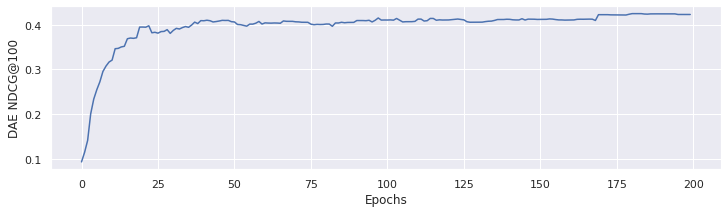

In [707]:
# Creating a new figure for plotting with specified size (width: 12, height: 3)
plt.figure(figsize=(12, 3))

# Plotting the values of NDCG for validation data across epochs
plt.plot(ndcgs_vad)

# Labeling the y-axis as "Validation NDCG@100"
plt.ylabel("DAE NDCG@100")

# Labeling the x-axis as "Epochs"
plt.xlabel("Epochs")
pass

In [708]:
print("DAE Recall@20 = " , (np.nanmean(r20_list)))
print("DAE Recall@50 = " ,(np.nanmean(r50_list)))

DAE Recall@20 =  0.376
DAE Recall@50 =  0.63803125


# MultiVAE Traing & Validation 

In [709]:
# Resetting the default TensorFlow graph
tf.compat.v1.reset_default_graph()

# Defining the dimensions for the neural network layers [200, 600, n_items]
p_dims = [200, 600, n_items]

# Creating an instance of the MultiVAE class with specified parameters
vae = MultiVAE(p_dims, lam=0.01, random_seed=98765)

# Building the TensorFlow computation graph for the VAE model
saver, logits_var, loss_var, train_op_var, merged_var = vae.build_graph() #Graph construction

# Creating a TensorFlow variable initialized with a value of 0.0 for NDCG evaluation
ndcg_var = tf.Variable(0.0)

# Placeholder for NDCG values of type float64 with unspecified shape
ndcg_dist_var = tf.compat.v1.placeholder(dtype=tf.float64, shape=None)

# Creating a summary for NDCG at k for validation
ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)

# Creating a summary for the histogram of NDCG at k for validation
ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)

#merged_valid = tf.compat.v1.summary.merge([ndcg_summary, ndcg_dist_summary])

Tensor("dropout/Mul:0", shape=(None, 219), dtype=float32)


In [710]:
n_epochs = 200 # Setting the number of epochs for training the model to 200

In [711]:
ndcgs_vad = []# Empty list to store NDCG values for validation
i=0# Counter variable initialization
n100_list, r20_list, r50_list = [], [], []
with tf.compat.v1.Session() as sess:# TensorFlow session context manager
    # Initializing global variables within the session
    init = tf.compat.v1.global_variables_initializer()
    sess.run(init)

    best_ndcg = -np.inf # Initializing the best NDCG variable to negative infinity

    update_count = 0.0 # Initializing update_count for annealing
    
    # Training for one epoch
    for epoch in range(n_epochs):# Looping through the specified number of epochs for training
        i+=1# Incrementing the counter
        idxlist = random.sample(list(idxlist), len(list(idxlist)))
        # train for one epoch
        for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)
            X = train_data[idxlist[st_idx:end_idx]]# Preparing input data for training
            
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')           
            
            # Annealing schedule
            if total_anneal_steps > 0:
                anneal = min(anneal_cap, 1. * update_count / total_anneal_steps)
            else:
                anneal = anneal_cap
            
            # Creating a feed dictionary for the model training
            feed_dict = {vae.input_ph: X, 
                         vae.keep_prob_ph: 0.5, 
                         vae.anneal_ph: anneal,
                         vae.is_training_ph: 1}        
            sess.run(train_op_var, feed_dict=feed_dict) # Running the training operation for the model

            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
            update_count += 1
        
         # Computing validation NDCG
        ndcg_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
            X = val_data_train[idxlist_vad[st_idx:end_idx]]
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')
            
          # Getting predictions for validation data
            pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X,vae.keep_prob_ph: 0.5, 
                         vae.anneal_ph: anneal,
                         vae.is_training_ph: 1} )
            # exclude examples from training and validation (if any)
            pred_val[X.nonzero()] = -np.inf
            ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, val_data_test[idxlist_vad[st_idx:end_idx]], k=100))
            r20_list.append(Recall_at_k_batch(pred_val, val_data_test[idxlist_vad[st_idx:end_idx]], k=20))
            r50_list.append(Recall_at_k_batch(pred_val, val_data_test[idxlist_vad[st_idx:end_idx]], k=50))

    
        print("Iteración: ", i ) # Printing iteration and mean NDCG for validation
        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_dist = np.nan_to_num(ndcg_dist)
        ndcg_ = ndcg_dist.mean() * 100
        print("Mean: ", ndcg_)
        ndcgs_vad.append(ndcg_)# Appending the mean NDCG to the list
        # update the best model (if necessary)
        if ndcg_ > best_ndcg:
            saver.save(sess, '{}/model'.format(chkpt_dir))
            best_ndcg = ndcg_
        


r20_list = np.concatenate(r20_list)
r50_list = np.concatenate(r50_list)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Iteración:  1
Mean:  0.2083989171888481
Iteración:  2
Mean:  0.1091639100091735
Iteración:  3
Mean:  0.13722700295174967
Iteración:  4
Mean:  0.17227502242020296
Iteración:  5
Mean:  0.13558848571411336
Iteración:  6
Mean:  0.2407723443036775
Iteración:  7
Mean:  0.18706706251435007
Iteración:  8
Mean:  0.2693704645729751
Iteración:  9
Mean:  0.27785853958770523
Iteración:  10
Mean:  0.39578680226474444
Iteración:  11
Mean:  0.3069913841492832
Iteración:  12
Mean:  0.3581273506535167
Iteración:  13
Mean:  0.374312882170551
Iteración:  14
Mean:  0.38900112968801925
Iteración:  15
Mean:  0.4860309197713641
Iteración:  16
Mean:  0.3979538970846988
Iteración:  17
Mean:  0.47851835268625215
Iteración:  18
Mean:  0.43441821811021564
Iteración:  19
Mean:  0.4196083031576775
Iteración:  20
Mean:  0.4405921750543545
Iteración:  21
Mean:  0.42398195364992414
Iteración:  22
Mean:  0.43625981486497317
Iteración:  23
Mean:  0.42978953520959884
Iteración:  24
Mean:  0.43207744026655254
Iteración:  2

Measurement of average algorithm performance:

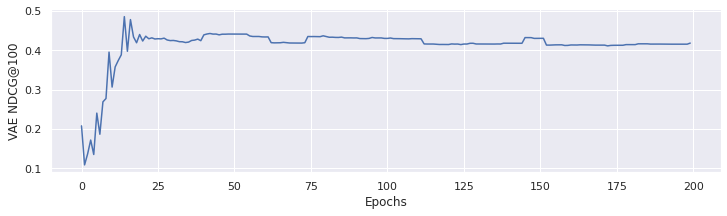

In [712]:
plt.figure(figsize=(12, 3))# Creating a new figure for plotting with specified size (width: 12, height: 3)
plt.plot(ndcgs_vad)# Plotting the values of NDCG for validation data across epochs
plt.ylabel("VAE NDCG@100")# Labeling the y-axis as "Validation NDCG@100"
plt.xlabel("Epochs")# Labeling the x-axis as "Epochs"
pass

In [713]:
print("VAE Recall@20 = " , (np.nanmean(r20_list)))
print("VAE Recall@50 = " ,(np.nanmean(r50_list)))

VAE Recall@20 =  0.37096874999999996
VAE Recall@50 =  0.6079999999999999


# Testing 

### Load the test data and compute test metrics

In [714]:
test_data_tr, test_data_te = load_tr_te_data(
    os.path.join(pro_dir, 'test_tr.csv'),
    os.path.join(pro_dir, 'test_te.csv'))

In [715]:
N_test = test_data_tr.shape[0]
idxlist_test = range(N_test)
batch_size_test = 2000

In [716]:
# Resetting the default TensorFlow graph
tf.compat.v1.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0)
saver, logits_var, _, _, _ = vae.build_graph()    

Tensor("dropout/Mul:0", shape=(None, 219), dtype=float32)


Load the best performing model on the validation set

In [717]:
chkpt_dir = '/volmount/chkpt/ml-20m/DAE/{}'.format(arch_str)
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: /volmount/chkpt/ml-20m/DAE/I-200-I


In [718]:
n100_list, r20_list, r50_list = [], [], []

# TensorFlow session context manager
with tf.compat.v1.Session() as sess:
    saver.restore(sess, '{}/model'.format(chkpt_dir))

    for bnum, st_idx in enumerate(range(0, N_test, batch_size_test)):
        end_idx = min(st_idx + batch_size_test, N_test)
        X = test_data_tr[idxlist_test[st_idx:end_idx]]

        if sparse.isspmatrix(X):
            X = X.toarray()
        X = X.astype('float32')

        pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X})
        # exclude examples from training and validation (if any)
        pred_val[X.nonzero()] = -np.inf
        n100_list.append(NDCG_binary_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=100))
        r20_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=20))
        r50_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=50))
    
n100_list = np.concatenate(n100_list)
r20_list = np.concatenate(r20_list)
r50_list = np.concatenate(r50_list)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [719]:
print("Test NDCG@100 = " , (np.nanmean(n100_list)))
print("Test Recall@20 = " , (np.nanmean(r20_list)))
print("Test Recall@50 = " ,(np.nanmean(r50_list)))

Test NDCG@100 =  0.1777299186717457
Test Recall@20 =  0.125
Test Recall@50 =  0.5


# Results
compared to the paper results we have slight enhancment sinice 
*  we have got 0.431 NDCG at Multi-DAE 
*  while we have got 0.52 at Multi-VAE.

Intuitively, Mult-vae and Mult-dae have roughly similar performance. but Mult-vae imposes stronger modeling assumptions and therefore could be more robust when user-item interaction data is scarce.

# Future Work
To prevent Bias we used an undersampling technique that handles imbalanced data to prevent Variance we used Regularization L2 and to prevent overfitting but we still gained low NDCG so in the future, we want to Increase the size of the dataset to prevent underfiting or use simpler models that are less prone to overfitting, especially when the amount of data is limited.

# Conclusion: 
In the end, our journey through this recommendation system course project has been an enriching experience. We have not only explored a research paper and implemented its findings but have also gone above and beyond, striving to improve and innovate within the field. Through our collective efforts, dedication, and unwavering commitment, we hope to contribute to the advancement of recommendation systems and leave a lasting impact on the field as aspiring researchers and engineers.